## Import the packages

In [11]:
import pandas as pd
import numpy as np

from sklearn.metrics import accuracy_score,f1_score
from lime.lime_tabular import LimeTabularExplainer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

import matplotlib.pyplot as plt
from lazypredict.Supervised import LazyClassifier
from sklearn.model_selection import train_test_split

from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

## Pre processing 

In [9]:
file_path = "./recruitmentdataset-2022-1.3.csv"  
data = pd.read_csv(file_path)
print(data.info())

#Identify the columns by their types
numerical_cols = ['age', 'ind-university_grade', 'ind-languages']
categorical_cols = ['gender', 'nationality', 'sport', 'ind-degree', 'company']
boolean_cols = ['ind-debateclub', 'ind-programming_exp', 'ind-international_exp', 'ind-entrepeneur_exp', 'ind-exact_study', 'decision']

# Convert boolean columns to int (0, 1)
data[boolean_cols] = data[boolean_cols].astype(int)

# Define the ColumnTransformer: this will apply transformations to the specified columns
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(), categorical_cols)
    ],
    remainder='passthrough')  # Include columns that are not transformed

# Apply the transformations to the dataset, excluding the 'Id' and boolean columns for now
data_for_preprocessing = data.drop(columns=['Id'] + boolean_cols)
data_preprocessed = preprocessor.fit_transform(data_for_preprocessing)

# The boolean columns were excluded from transformation, so we need to append them manually
# Append the boolean columns back to the transformed data
data_preprocessed_with_boolean = pd.concat([pd.DataFrame(data_preprocessed), data[boolean_cols].reset_index(drop=True)], axis=1)

#  Get the feature names after one-hot encoding
ohe_feature_names = preprocessor.named_transformers_['cat'].get_feature_names_out(input_features=categorical_cols)
all_feature_names = numerical_cols + list(ohe_feature_names) + boolean_cols

# Correct the column names in the DataFrame
data_preprocessed_with_boolean.columns = all_feature_names

feature_names = data_preprocessed_with_boolean.drop(columns=['decision']).columns.tolist()

data_preprocessed_with_boolean.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   Id                     4000 non-null   object
 1   gender                 4000 non-null   object
 2   age                    4000 non-null   int64 
 3   nationality            4000 non-null   object
 4   sport                  4000 non-null   object
 5   ind-university_grade   4000 non-null   int64 
 6   ind-debateclub         4000 non-null   bool  
 7   ind-programming_exp    4000 non-null   bool  
 8   ind-international_exp  4000 non-null   bool  
 9   ind-entrepeneur_exp    4000 non-null   bool  
 10  ind-languages          4000 non-null   int64 
 11  ind-exact_study        4000 non-null   bool  
 12  ind-degree             4000 non-null   object
 13  company                4000 non-null   object
 14  decision               4000 non-null   bool  
dtypes: bool(6), int64(3),

,age,ind-university_grade,ind-languages,gender_female,gender_male,gender_other,nationality_Belgian,nationality_Dutch,nationality_German,sport_Chess,...,company_A,company_B,company_C,company_D,ind-debateclub,ind-programming_exp,ind-international_exp,ind-entrepeneur_exp,ind-exact_study,decision
0,-0.78,1.29,-0.39,1.00,0.00,0.00,0.00,0.00,1.00,0.00,...,1.00,0.00,0.00,0.00,0,0,0,0,1,1
1,-0.06,0.78,0.78,0.00,1.00,0.00,0.00,0.00,1.00,0.00,...,1.00,0.00,0.00,0.00,0,1,0,0,1,0
2,-1.13,0.78,-1.56,1.00,0.00,0.00,0.00,1.00,0.00,0.00,...,1.00,0.00,0.00,0.00,0,1,1,0,1,0
3,-0.78,1.29,-0.39,0.00,1.00,0.00,0.00,1.00,0.00,0.00,...,1.00,0.00,0.00,0.00,0,1,0,0,1,1
4,-0.06,-0.57,-0.39,1.00,0.00,0.00,0.00,0.00,1.00,0.00,...,1.00,0.00,0.00,0.00,0,0,0,0,0,1


## Modeling

> At first, we are going to benchmark some models thanks to the LazyPredict library that will compute various models quickly for us, then we are going to choose the best one in order to focus later on it, with some optimization for example. 

In [10]:
# Since LazyPredict doesn't handle DataFrame input directly, we'll use the preprocessed data as numpy arrays.
# Splitting the data into features (X) and target (y) for modeling
X = data_preprocessed_with_boolean.drop(columns=['decision']).values
y = data_preprocessed_with_boolean['decision'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the LazyClassifier to fit on the training data
clf = LazyClassifier(verbose=0, ignore_warnings=True, custom_metric=None)

# Fit and evaluate the models
models, predictions = clf.fit(X_train, X_test, y_train, y_test)

# Display the performance metrics of the models
models

  0%|          | 0/29 [00:00<?, ?it/s]

 97%|█████████▋| 28/29 [00:15<00:00,  1.39it/s]

[LightGBM] [Info] Number of positive: 1034, number of negative: 2166
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003808 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 129
[LightGBM] [Info] Number of data points in the train set: 3200, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.323125 -> initscore=-0.739447
[LightGBM] [Info] Start training from score -0.739447


100%|██████████| 29/29 [00:16<00:00,  1.73it/s]


,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
XGBClassifier,0.86,0.84,0.84,0.86,1.84
LGBMClassifier,0.86,0.84,0.84,0.86,1.33
DecisionTreeClassifier,0.83,0.80,0.80,0.83,0.10
RandomForestClassifier,0.85,0.80,0.80,0.84,0.81
BaggingClassifier,0.84,0.79,0.79,0.84,0.16
SVC,0.83,0.78,0.78,0.83,0.81
ExtraTreesClassifier,0.81,0.77,0.77,0.81,0.57
NuSVC,0.82,0.75,0.75,0.81,0.86
ExtraTreeClassifier,0.76,0.71,0.71,0.76,0.02


> As we can see, XG Boost and Light GBM seems to be the best models to perform with our data, in terms of accuracy, F1-score and time taken. 
>
> We are going to focus on XGBoost. 


## Optimization 


### Optimization with GridSearchCV

In [10]:
# Optimization of the model 


# Initialize the XGBClassifier with default parameters
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss')

# Define a grid of parameters to search over
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 4, 5],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 0.9, 1],
    'colsample_bytree': [0.8, 0.9, 1],
}

# Setup the grid search
grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2, scoring='accuracy')

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Find the best parameters and the best model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# Predictions with the best model
y_pred = best_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

best_params, accuracy

Fitting 3 folds for each of 243 candidates, totalling 729 fits


({'colsample_bytree': 1,
  'learning_rate': 0.2,
  'max_depth': 3,
  'n_estimators': 200,
  'subsample': 1},
 0.8725)

In [13]:
# Implementing the optimized XGBClassifier with the provided best parameters from the grid search
optimized_xgb = XGBClassifier(
    colsample_bytree=1,
    learning_rate=0.2,
    max_depth=3,
    n_estimators=200,
    subsample=1,
    use_label_encoder=False,
    eval_metric='logloss'
)
if isinstance(X_train, np.ndarray):
    X_train_df = pd.DataFrame(X_train, columns=feature_names)
else:
    X_train_df = X_train  # Assumant que X_train est déjà un DataFrame avec des noms de colonnes

# Fitting the optimized model on the training data
optimized_xgb.fit(X_train, y_train)

# Making predictions with the optimized model on the test data
y_pred_optimized = optimized_xgb.predict(X_test)
accuracy_optimized = accuracy_score(y_test, y_pred_optimized)

print(f"Accuracy of the model XGBoost Optimized : {accuracy_optimized}")

Accuracy of the model XGBoost Optimized : 0.8725


> Let's try a new way/approach to optimize a model, thanks to Optuna. 

### Optimization with Optuna

In [17]:
import optuna
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score

def objective(trial):
    # Define the hyperparameters to tune
    param_grid = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 300),
        'max_depth': trial.suggest_int('max_depth', 3, 7),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'subsample': trial.suggest_float('subsample', 0.7, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.7, 1.0),
    }
    
    
    # Initialize the XGBClassifier with suggested parameters
    model = XGBClassifier(**param_grid, use_label_encoder=False, eval_metric='logloss', random_state=42)
    
    # Perform cross-validation and return the average accuracy
    return cross_val_score(model, X_train, y_train, n_jobs=-1, cv=3).mean()

# Create a study object and optimize the objective function
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10)  # Adjust the number of trials as necessary

# Output the optimization results
print('Number of trials finished: ', len(study.trials))
print(f"Best trial accuracy: {study.best_trial.value}")
print(f"Best hyperparameters: {study.best_trial.params}")

[I 2024-03-17 02:22:36,482] A new study created in memory with name: no-name-8eb01bd6-bf81-4af3-a519-9108d1430287


[I 2024-03-17 02:22:37,658] Trial 0 finished with value: 0.8506262407444204 and parameters: {'n_estimators': 167, 'max_depth': 5, 'learning_rate': 0.18475405154468844, 'subsample': 0.904639312398749, 'colsample_bytree': 0.8407688352128612}. Best is trial 0 with value: 0.8506262407444204.
[I 2024-03-17 02:22:39,173] Trial 1 finished with value: 0.8537493853058349 and parameters: {'n_estimators': 145, 'max_depth': 6, 'learning_rate': 0.1487748927565002, 'subsample': 0.8635723519353151, 'colsample_bytree': 0.7646601562003329}. Best is trial 1 with value: 0.8537493853058349.
[I 2024-03-17 02:22:40,023] Trial 2 finished with value: 0.8609381566384332 and parameters: {'n_estimators': 124, 'max_depth': 4, 'learning_rate': 0.10471463992550618, 'subsample': 0.8446771912346719, 'colsample_bytree': 0.9780216323278164}. Best is trial 2 with value: 0.8609381566384332.
[I 2024-03-17 02:22:41,284] Trial 3 finished with value: 0.8540626668612589 and parameters: {'n_estimators': 237, 'max_depth': 4, 'l

Number of trials finished:  10
Best trial accuracy: 0.8618733123384871
Best hyperparameters: {'n_estimators': 84, 'max_depth': 4, 'learning_rate': 0.2265368085691294, 'subsample': 0.8813805325359543, 'colsample_bytree': 0.705112822360697}


> As we have better accuracy with GridSearchCV, we are going to choose this approach to optimize our model. 
>
> Our final model is **optimized_xgb** .

## Feature importance 

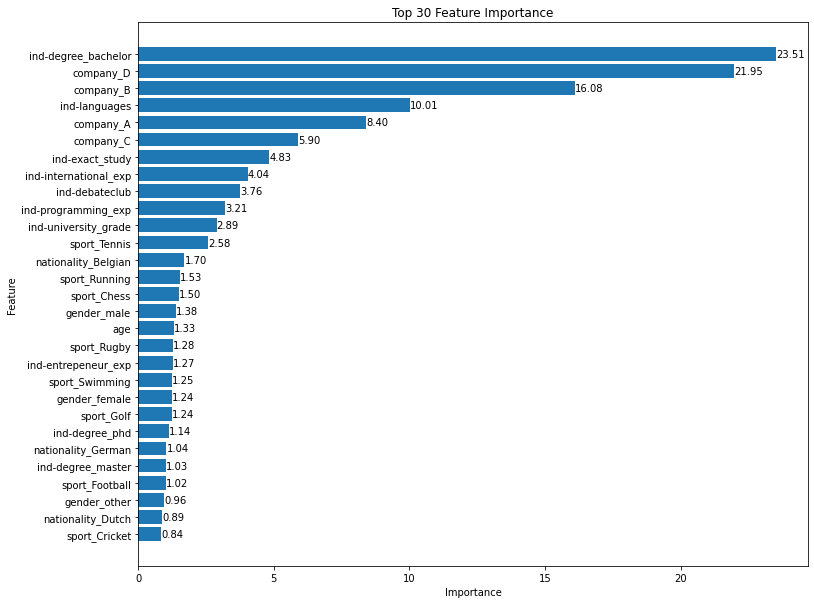

In [14]:
# Extract infos
feature_importances = optimized_xgb.get_booster().get_score(importance_type='gain')
feature_importances_df = pd.DataFrame(feature_importances.items(), columns=['Feature', 'Importance'])

# Mapping of generic names to reals columns. 
feature_importances_df['Feature'] = feature_importances_df['Feature'].apply(lambda x: feature_names[int(x.replace('f', ''))])

# sort features
feature_importances_df = feature_importances_df.sort_values(by='Importance', ascending=False)


plt.figure(figsize=(12, 10))
bars = plt.barh(feature_importances_df['Feature'][:30], feature_importances_df['Importance'][:30])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Top 30 Feature Importance')
for bar in bars:
    plt.text(bar.get_width(), bar.get_y() + bar.get_height() / 2,
             f'{bar.get_width():.2f}',
             va='center', ha='left')
plt.gca().invert_yaxis()  # Invert the y axis to get descending importance from top to bottom
plt.show() 

## Interpretability with Shap

> **SHAP (SHapley Additive exPlanations)** is an excellent package offering a unified approach to explaining the output of any Machine Learning model. SHAP links game theory to local explanations, based on Shapley values. 
>
> In general, model predictions can be explained by assuming that each explanatory variable is a "player" in a game where the prediction is the payoff. 
>
> The Shapley value - a method derived from cooperative game theory - tells us how to distribute the "payoff" fairly between the variables.


100%|===================| 3196/3200 [00:15<00:00]        

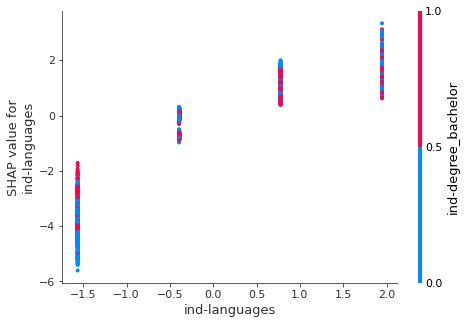

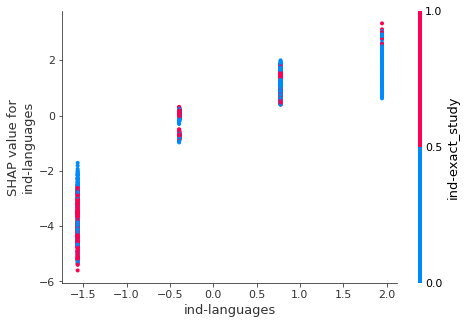

In [24]:
import shap

#  init Shap explainer
explainer = shap.Explainer(optimized_xgb, X_train_df)

# Calculate SHAP values
shap_values = explainer(X_train_df)

# Display plot dependance for one specific feature
shap.dependence_plot('ind-languages', shap_values.values, X_train_df,interaction_index='ind-degree_bachelor')
shap.dependence_plot('ind-languages', shap_values.values, X_train_df,interaction_index='ind-exact_study')


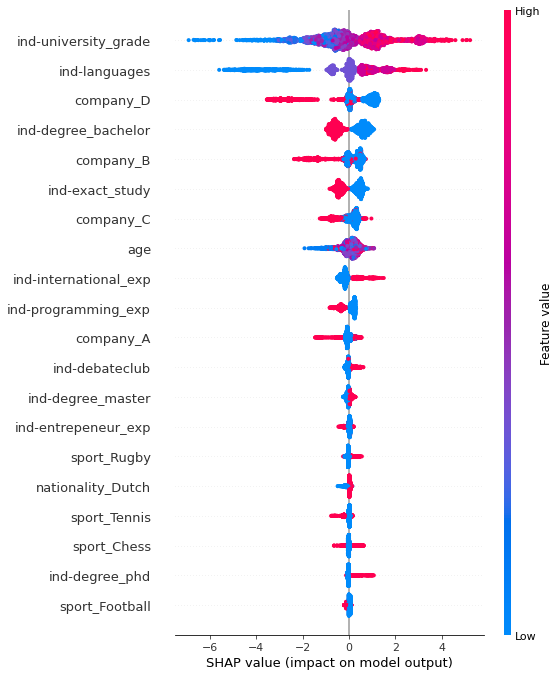

In [27]:
# Global Visualisation  : features importance based on SHAP
shap.summary_plot(shap_values, X_train_df, feature_names=feature_names)

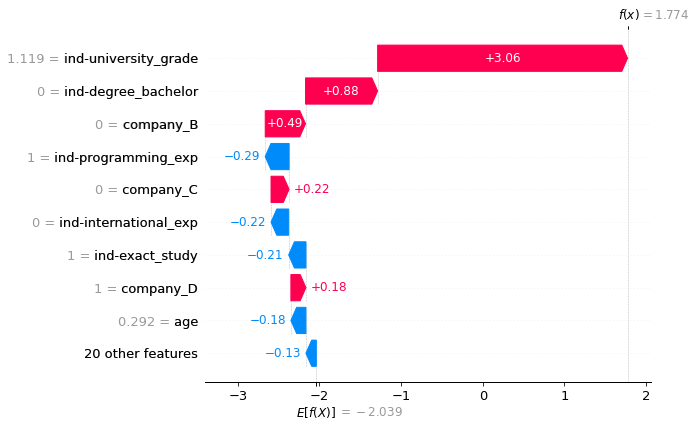

In [29]:
# Local Visualisation : interpretability of one specific prediction, here the number 0
shap.plots.waterfall(shap_values[0], max_display=10)

> We can clearly see the shap value of each feature added, regarding the value of the feature, that will explain this specific prediction.

## Interpretabilty with LIME 

> LIME, which stands for **Local Interpretable Model-agnostic Explanations**, is a technique designed to explain the predictions of any machine learning model in an interpretable and understandable manner. The main idea behind LIME is to approximate any complex, black-box model locally with a simpler, interpretable model around the prediction being explained.

In [31]:
from lime import lime_tabular

# Initialize the LIME explainer LIME for tabular data
explainer = lime_tabular.LimeTabularExplainer(
    training_data=X_train,
    feature_names=feature_names,
    class_names=['Negative', 'Positive'],
    mode='classification')

# select the specific instance to explain
idx_to_explain = 0  

# Generate the result for this instance
exp = explainer.explain_instance(
    data_row=X_test[idx_to_explain],
    predict_fn=optimized_xgb.predict_proba,
    num_features=10)  

# Display the result
exp.show_in_notebook(show_table=True, show_all=False)


> Thanks to these results, we can conclude that : 
> - For the Positive influences : 
>> - **ind-university_grade (1.96):** This characteristic has the strongest positive impact on prediction. A higher university grade is strongly associated with a favorable outcome according to the model. This suggests that the model significantly values academic performance.
>> - **ind-languages (0.78):** The number of languages spoken also has a positive impact, altough less pronounced than academic grades. This indicates that, according to the model, the ability to speak several languages is a positive asset, but with less importance than academic performance.
>
> - For the Negative influences : 
>> - **ind-degree_bachelor (1.00):** Having only a bachelor's degree seems to have a negative impact on the model's prediction, with moderate relative importance. This could indicate that the model favors candidates with higher levels of education or specific qualifications beyond a bachelor's degree.
>> - **ind-international_exp (0.00):** International experience has no impact on the prediction for this specific instance. This could mean that, for this particular prediction, having or not having international experience makes no difference to the outcome according to the model.
>> - **ind-exact_study (1.00):** Studying in a specific field (supposedly technical or specialized) also seems to be perceived negatively by the model in this context.  This may reflect a preference for more generalist profiles or with a certain diversity in their academic background.
>> - .... 
> - Also, according to LIME : 
>> - **company_C, company_B, company_D (0.00):** Having worked for these companies had no positive impact on the prediction. This may indicate that, from the model's point of view and for this particular instance, work experience at these companies is neither an advantage nor a disadvantage, or that the effect of these companies is overshadowed by other, more influential characteristics.
>>
>> - **gender_other (0.00):** The "other" gender characteristic also did not positively influence the prediction. This could mean that the candidate's gender, in this case specified as "other", is not a factor that the model uses to favor or disfavor a candidate for this particular prediction.
